# **Preprocessing of the COCO Dataset**

The [COCO (Common Objects in Context)](https://cocodataset.org/#home) dataset is a large-scale collection designed for object detection, segmentation, and captioning tasks. Its primary goal is to drive research across a diverse range of object categories and has become a benchmark for evaluating computer vision models. For object detection, the training set comprises 117,266 images with at least one annotation, totaling 860,001 annotations distributed across 80 classes and 12 superclasses. In this notebook, a specialized preprocessing approach will focus exclusively on extracting images from the training set containing a single object instance, tailored for single-object detection tasks. The described procedure is fully replicable for preprocessing the entire dataset. The resulting dataset, named **COCO-SingleBBox**, will be used to demonstrate single-instance object detection using **PyTorch** and transfer learning with the [EfficientNetV2-S](https://arxiv.org/abs/2104.00298) model.

## **Imports**

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import drive
from tqdm.auto import tqdm
from glob import glob
import pandas as pd
from PIL import Image
import shutil
import os
import json

## **Parameters**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
SEED = 123
dataset_path = "/content/COCO-SingleBBox"
zip_data_path = "/content/drive/MyDrive/Datasets/COCO-SingleBBox.zip"
new_size = (384, 384, 3)
val_split = 0.2

## **Download and Extract the Dataset**

The download links for images and annotations for a specific year are available on COCO's [official website](https://cocodataset.org/#download). In this case, the training images and annotations from the most recent version, corresponding to the year 2017, will be downloaded.

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2024-11-23 16:51:05--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.131.121, 3.5.11.226, 52.217.70.180, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.131.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  51.2MB/s    in 5m 40s  

2024-11-23 16:56:45 (54.2 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2024-11-23 16:56:46--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.135.193, 52.217.112.97, 52.216.215.89, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.135.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annot

In [ ]:
!unzip -q train2017.zip
!unzip -q annotations_trainval2017.zip

## **Preprocess the Dataset**

In [ ]:
with open("/content/annotations/instances_train2017.json", "r") as f:
  annotations = json.load(f)

annotations.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [ ]:
# View an example and the key lengths of the annotations dictionary
id = 0

print(len(annotations["images"]), annotations["images"][id])
print(len(annotations["annotations"]), annotations["annotations"][id])
print(len(annotations["categories"]), annotations["categories"][id])

118287 {'license': 3, 'file_name': '000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}
860001 {'segmentation': [[239.97, 260.24, 222.04, 270.49, 199.84, 253.41, 213.5, 227.79, 259.62, 200.46, 274.13, 202.17, 277.55, 210.71, 249.37, 253.41, 237.41, 264.51, 242.54, 261.95, 228.87, 271.34]], 'area': 2765.1486500000005, 'iscrowd': 0, 'image_id': 558840, 'bbox': [199.84, 200.46, 77.71, 70.88], 'category_id': 58, 'id': 156}
80 {'supercategory': 'person', 'id': 1, 'name': 'person'}


In [ ]:
# Extract the classes and superclasses
class_names = sorted([dic["name"] for dic in annotations["categories"]])
supercategories = sorted(set(dic["supercategory"] for dic in annotations["categories"]))

print(len(class_names), len(supercategories))
print(class_names)
print(supercategories)

80 12
['airplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'clock', 'couch', 'cow', 'cup', 'dining table', 'dog', 'donut', 'elephant', 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'hair drier', 'handbag', 'horse', 'hot dog', 'keyboard', 'kite', 'knife', 'laptop', 'microwave', 'motorcycle', 'mouse', 'orange', 'oven', 'parking meter', 'person', 'pizza', 'potted plant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'sheep', 'sink', 'skateboard', 'skis', 'snowboard', 'spoon', 'sports ball', 'stop sign', 'suitcase', 'surfboard', 'teddy bear', 'tennis racket', 'tie', 'toaster', 'toilet', 'toothbrush', 'traffic light', 'train', 'truck', 'tv', 'umbrella', 'vase', 'wine glass', 'zebra']
['accessory', 'animal', 'appliance', 'electronic', 'food', 'furniture', 'indoor', 'kitchen', 'outdoor', 'person', 'sports', 'vehicle

In [ ]:
# Merge images, annotations, and categories into a single DataFrame
df = pd.merge(
    left=pd.DataFrame(annotations["images"], columns=["file_name", "id"]),
    right=pd.DataFrame(annotations["annotations"], columns=["image_id", "bbox", "category_id"]),
    how="inner",
    left_on="id",
    right_on="image_id"
)
df = pd.merge(
    left=df,
    right=pd.DataFrame(annotations["categories"], columns=["id", "name"]),
    how="inner",
    left_on="category_id",
    right_on="id"
)

df.head(5)

,file_name,id_x,image_id,bbox,category_id,id_y,name
0,000000391895.jpg,391895,391895,"[359.17, 146.17, 112.45, 213.57]",4,4,motorcycle
1,000000391895.jpg,391895,391895,"[339.88, 22.16, 153.88, 300.73]",1,1,person
2,000000391895.jpg,391895,391895,"[471.64, 172.82, 35.92, 48.1]",1,1,person
3,000000391895.jpg,391895,391895,"[486.01, 183.31, 30.63, 34.98]",2,2,bicycle
4,000000522418.jpg,522418,522418,"[382.48, 0.0, 256.8, 474.31]",1,1,person


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860001 entries, 0 to 860000
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   file_name    860001 non-null  object
 1   id_x         860001 non-null  int64 
 2   image_id     860001 non-null  int64 
 3   bbox         860001 non-null  object
 4   category_id  860001 non-null  int64 
 5   id_y         860001 non-null  int64 
 6   name         860001 non-null  object
dtypes: int64(4), object(3)
memory usage: 45.9+ MB


In [ ]:
# Group the DataFrame by image to extract all its bounding boxes and classes
df = df.drop(columns=["id_x", "image_id", "category_id","id_y"])
df = df.groupby("file_name", as_index=False).agg({"bbox": list, "name": list})

df.head(5)

,file_name,bbox,name
0,000000000009.jpg,"[[1.08, 187.69, 611.59, 285.84], [311.73, 4.31...","[bowl, bowl, broccoli, bowl, orange, orange, o..."
1,000000000025.jpg,"[[385.53, 60.03, 214.97, 297.16], [53.01, 356....","[giraffe, giraffe]"
2,000000000030.jpg,"[[204.86, 31.02, 254.88, 324.12], [237.56, 155...","[potted plant, vase]"
3,000000000034.jpg,"[[0.96, 20.06, 441.23, 379.15]]",[zebra]
4,000000000036.jpg,"[[0.0, 50.12, 457.68, 430.35], [167.58, 162.89...","[umbrella, person]"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117266 entries, 0 to 117265
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   file_name  117266 non-null  object
 1   bbox       117266 non-null  object
 2   name       117266 non-null  object
dtypes: object(3)
memory usage: 2.7+ MB


In [ ]:
# There are 1021 images without any bounding box
118287 - 117266

1021

In [ ]:
# Consider only images with a single bounding box
df = df[df.bbox.apply(len) == 1]

# Filter the classes with 250 images or more
counts = df.name.value_counts()
class_names = counts[counts >= 250].index.tolist()
class_names

[['airplane'],
 ['train'],
 ['clock'],
 ['toilet'],
 ['bird'],
 ['giraffe'],
 ['bear'],
 ['stop sign'],
 ['fire hydrant'],
 ['zebra'],
 ['cat'],
 ['elephant'],
 ['bench'],
 ['vase'],
 ['dog'],
 ['pizza'],
 ['bed'],
 ['horse']]

In [ ]:
# Filter the DataFrame to include only the classes present in 'class_names'
df = df[df.name.isin(class_names)]

# Flatten the 'name' and 'bbox' columns
df["bbox"] = df.bbox.apply(lambda x: x[0])
df["name"] = df.name.apply(lambda x: x[0])

df.head(5)

<ipython-input-15-438dd36f9600>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bbox"] = df.bbox.apply(lambda x: x[0])
<ipython-input-15-438dd36f9600>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["name"] = df.name.apply(lambda x: x[0])


,file_name,bbox,name
3,000000000034.jpg,"[0.96, 20.06, 441.23, 379.15]",zebra
5,000000000042.jpg,"[214.15, 41.29, 348.26, 243.78]",dog
14,000000000078.jpg,"[359.8, 2.07, 214.13, 235.91]",clock
15,000000000081.jpg,"[38.55, 40.48, 584.01, 318.02]",airplane
84,000000000472.jpg,"[394.86, 56.68, 87.21, 31.46]",airplane


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10135 entries, 3 to 117250
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  10135 non-null  object
 1   bbox       10135 non-null  object
 2   name       10135 non-null  object
dtypes: object(3)
memory usage: 316.7+ KB


In [ ]:
# Extract the final class names
class_names = df.name.sort_values().unique().tolist()
print(len(class_names))
print(class_names)

18
['airplane', 'bear', 'bed', 'bench', 'bird', 'cat', 'clock', 'dog', 'elephant', 'fire hydrant', 'giraffe', 'horse', 'pizza', 'stop sign', 'toilet', 'train', 'vase', 'zebra']


In [ ]:
# Function to normalize the bounding boxes to the 'albumentations' format
def normalize_bbox(row):
  width_img, height_img = Image.open(f"/content/train2017/{row['file_name']}").size
  cls = class_names.index(row["name"])
  xmin, ymin, width, height = tuple(row["bbox"])

  xmax = (xmin + width) / width_img
  ymax = (ymin + height) / height_img
  xmin /= width_img
  ymin /=  height_img

  return [cls, xmin, ymin, xmax, ymax]

In [ ]:
# Normalize the bounding boxes and find the path of each image
df["label"] = df.apply(normalize_bbox, axis=1)
df["image_path"] = df.file_name.apply(lambda x: os.path.join(dataset_path, f"images/{x}"))
df = df.drop(columns=["file_name", "bbox"])

df.head(5)

,name,label,image_path
3,zebra,"[17, 0.0015, 0.0472, 0.690921875, 0.9393176470...",/content/COCO-SingleBBox/images/000000000034.jpg
5,dog,"[7, 0.334609375, 0.0863807531380753, 0.8787656...",/content/COCO-SingleBBox/images/000000000042.jpg
14,clock,"[6, 0.5879084967320262, 0.0033823529411764705,...",/content/COCO-SingleBBox/images/000000000078.jpg
15,airplane,"[0, 0.06023437499999999, 0.0952470588235294, 0...",/content/COCO-SingleBBox/images/000000000081.jpg
84,airplane,"[0, 0.6169687500000001, 0.25079646017699114, 0...",/content/COCO-SingleBBox/images/000000000472.jpg


In [ ]:
# Split the DataFrame into training and validation sets
df_train, df_val = train_test_split(df, test_size=val_split, random_state=SEED, stratify=df.name)

del df
len(df_train), len(df_val)

(8108, 2027)

In [ ]:
df_train.name.value_counts().sort_values().values / df_val.name.value_counts().sort_values().values

array([3.98148148, 4.01724138, 3.98333333, 3.96721311, 4.        ,
       3.97297297, 3.98666667, 4.02597403, 4.        , 4.        ,
       4.00961538, 4.01801802, 4.01351351, 4.        , 3.98901099,
       3.99456522, 4.        , 4.00896861])

It can be seen that the distribution is maintained for each class, both in the training and validation DataFrames.

In [ ]:
# Function to save the images and DataFrames
def save_dataset(df, split="train"):
  images_path = os.path.join(dataset_path, "images")
  os.makedirs(images_path, exist_ok=True)

  for img_path in tqdm(df.image_path.values):
    shutil.copy(os.path.join("/content/train2017", os.path.basename(img_path)), img_path)

  df.to_csv(os.path.join(dataset_path, f"{split}_labels.csv"), index=False)

In [ ]:
save_dataset(df_train)
save_dataset(df_val, split="val")

  0%|          | 0/8108 [00:00<?, ?it/s]

  0%|          | 0/2027 [00:00<?, ?it/s]

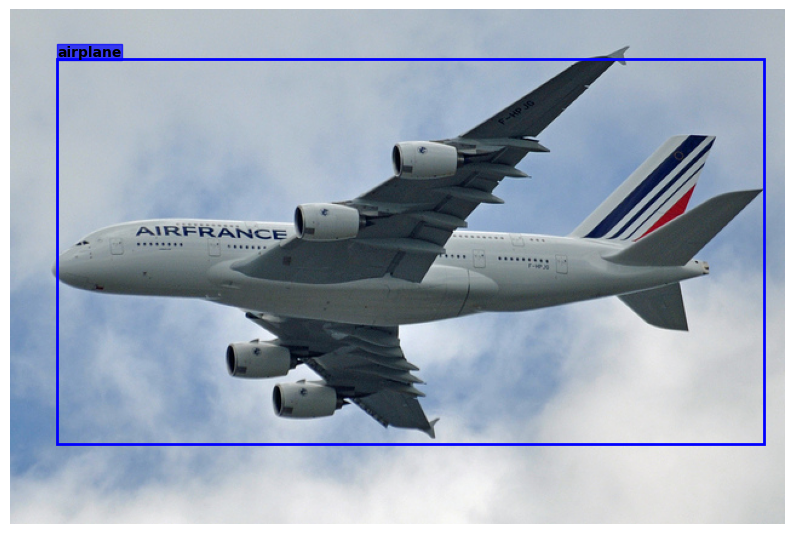

In [ ]:
# Visualization example
fig, ax = plt.subplots(1, figsize=(10, 10))
id = 15

image = Image.open(df_train.image_path[id])
shape = np.array(image).shape
ax.imshow(image)

label = df_train.label[id]
cls = label[0]
box = label[1:]

xmin, ymin, xmax, ymax = tuple(box)
xmin, xmax = xmin * shape[1], xmax * shape[1]
ymin, ymax = ymin * shape[0], ymax * shape[0]

rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor="blue", facecolor="none")
ax.add_patch(rect)

ax.text(
    x=xmin, y=ymin, s=class_names[cls],
    color="black", fontsize=10, fontweight="bold", ha="left", va="bottom",
    bbox={"boxstyle":"square,pad=0.05", "facecolor": "blue", "edgecolor": "blue", "alpha":0.7}
)

ax.axis("off");

In [ ]:
# Compress the dataset into a zip file and save it
!zip -r $zip_data_path COCO-SingleBBox -q